## Data Acquisition

In [24]:
import pandas as pd
from sqlalchemy import create_engine
from tmdbv3api import TMDb, Movie

## DATA STORAGE AND MODELING
# Replace with your MySQL credentials
username = 'root'
password = 'Samoxshamas'
database = 'movies_db'
host = 'localhost'

# Create connection
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}/{database}')


In [6]:
# Set up TMDb
tmdb = TMDb()
tmdb.api_key = '45e798874d6c74f0c90bec91a7ed6d69'  # replace with your key
tmdb.language = 'en'

# Initialize Movie API
tmdb_movie = Movie()



In [9]:
df_box = pd.read_csv('Top_1000_Highest_Grossing_Movies_Of_All_Time.csv')  

# Inspect columns
print(df_box.columns)
df_box.head()


Index(['Movie Title', 'Year of Realease', 'Genre', 'Movie Rating', 'Duration',
       'Gross', 'Worldwide LT Gross', 'Metascore', 'Votes', 'Logline'],
      dtype='object')


,Movie Title,Year of Realease,Genre,Movie Rating,Duration,Gross,Worldwide LT Gross,Metascore,Votes,Logline
0,Avatar,2009,"Action,Adventure,Fantasy",7.8,162,$760.51M,"$2,847,397,339",83,"1,236,962",A paraplegic Marine dispatched to the moon Pan...
1,Avengers: Endgame,2019,"Action,Adventure,Drama",8.4,181,$858.37M,"$2,797,501,328",78,"1,108,641",After the devastating events of Avengers: Infi...
2,Titanic,1997,"Drama,Romance",7.9,194,$659.33M,"$2,201,647,264",75,"1,162,142",A seventeen-year-old aristocrat falls in love ...
3,Star Wars: Episode VII - The Force Awakens,2015,"Action,Adventure,Sci-Fi",7.8,138,$936.66M,"$2,069,521,700",80,"925,551","As a new threat to the galaxy rises, Rey, a de..."
4,Avengers: Infinity War,2018,"Action,Adventure,Sci-Fi",8.4,149,$678.82M,"$2,048,359,754",68,"1,062,517",The Avengers and their allies must be willing ...


## PRE INTEGRATION

In [10]:
# Normalize titles for matching
df_box['title_norm'] = df_box['Movie Title'].str.lower().str.strip()

# Optional: convert revenue to numeric (remove $ and commas)
df_box['Worldwide LT Gross'] = df_box['Worldwide LT Gross'].replace(r'[\$,]', '', regex=True).astype(float)

# Preview
df_box[['Movie Title', 'Year of Realease', 'Worldwide LT Gross', 'title_norm']].head()

,Movie Title,Year of Realease,Worldwide LT Gross,title_norm
0,Avatar,2009,2.847397e+09,avatar
1,Avengers: Endgame,2019,2.797501e+09,avengers: endgame
2,Titanic,1997,2.201647e+09,titanic
3,Star Wars: Episode VII - The Force Awakens,2015,2.069522e+09,star wars: episode vii - the force awakens
4,Avengers: Infinity War,2018,2.048360e+09,avengers: infinity war


## Data Integration / Enrichment

Integration: Merged Box Office dataset with TMDb metadata using title_norm

Enrichment: Added TMDb ratings, genres, etc., to the Box Office dataset

Matches: 932 / 1000 movies matched

In [11]:
tmdb_movies_list = []
for title in df_box['Movie Title']:
    try:
        results = tmdb_movie.search(title)
        if results:
            m = results[0]  # take the first result
            tmdb_movies_list.append({
                'title': m.title,
                'release_year': int(m.release_date.split('-')[0]) if m.release_date else None,
                'genre': None,
                'director': None,
                'main_cast': None,
                'imdb_rating': None,
                'tmdb_rating': m.vote_average,
                'title_norm': m.title.lower().strip()
            })
    except:
        continue

df_tmdb = pd.DataFrame(tmdb_movies_list)
print("TMDb metadata fetched:", len(df_tmdb))

TMDb metadata fetched: 983


In [12]:
# Now again Assuming df_tmdb is your metadata DataFrame
df_tmdb['title_norm'] = df_tmdb['title'].str.lower().str.strip()

In [14]:
# Merge on normalized title
df_matches = pd.merge(df_tmdb, df_box, on='title_norm', how='inner', suffixes=('_tmdb','_box'))

print("Total TMDb movies fetched:", len(df_tmdb))
print("Total Box Office movies:", len(df_box))
print("Number of matches found:", len(df_matches))

# Preview matched entries
df_matches[['title', 'Movie Title', 'release_year', 'Year of Realease', 'Worldwide LT Gross']].head(10)


Total TMDb movies fetched: 983
Total Box Office movies: 1000
Number of matches found: 929


,title,Movie Title,release_year,Year of Realease,Worldwide LT Gross
0,Avatar,Avatar,2009.0,2009,2.847397e+09
1,Avengers: Endgame,Avengers: Endgame,2019.0,2019,2.797501e+09
2,Titanic,Titanic,1997.0,1997,2.201647e+09
3,Avengers: Infinity War,Avengers: Infinity War,2018.0,2018,2.048360e+09
4,Spider-Man: No Way Home,Spider-Man: No Way Home,2021.0,2021,1.911433e+09
5,The Lion King,The Lion King,1994.0,2019,1.663250e+09
6,The Lion King,The Lion King,1994.0,1994,1.063612e+09
7,The Avengers,The Avengers,2012.0,2012,1.518816e+09
8,Frozen II,Frozen II,2019.0,2019,1.450027e+09
9,Top Gun: Maverick,Top Gun: Maverick,2022.0,2022,1.440740e+09


## Data Storage

In [15]:
# Keep only relevant columns
df_final = df_matches[[
    'title', 'release_year', 'genre', 'director', 'main_cast',
    'imdb_rating', 'tmdb_rating', 'Movie Rating', 'Duration',
    'Worldwide LT Gross', 'Metascore', 'Votes', 'Logline'
]]

# Rename columns for clarity
df_final.rename(columns={
    'Movie Rating': 'mpaa_rating',
    'Duration': 'duration_minutes'
}, inplace=True)

df_final.head()

C:\Users\User\AppData\Local\Temp\ipykernel_2756\2357730397.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.rename(columns={


,title,release_year,genre,director,main_cast,imdb_rating,tmdb_rating,mpaa_rating,duration_minutes,Worldwide LT Gross,Metascore,Votes,Logline
0,Avatar,2009.0,None,None,None,None,7.594,7.8,162,2.847397e+09,83,"1,236,962",A paraplegic Marine dispatched to the moon Pan...
1,Avengers: Endgame,2019.0,None,None,None,None,8.237,8.4,181,2.797501e+09,78,"1,108,641",After the devastating events of Avengers: Infi...
2,Titanic,1997.0,None,None,None,None,7.903,7.9,194,2.201647e+09,75,"1,162,142",A seventeen-year-old aristocrat falls in love ...
3,Avengers: Infinity War,2018.0,None,None,None,None,8.235,8.4,149,2.048360e+09,68,"1,062,517",The Avengers and their allies must be willing ...
4,Spider-Man: No Way Home,2021.0,None,None,None,None,7.937,8.3,148,1.911433e+09,71,"735,006","With Spider-Man's identity now revealed, Peter..."


In [16]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
mongo_db = client["movies_db"]
mongo_collection = mongo_db["movies_enriched"]

records = df_final.to_dict(orient="records")
mongo_collection.delete_many({})
mongo_collection.insert_many(records)


InsertManyResult([ObjectId('69425ddb366f60d6f6fcde87'), ObjectId('69425ddb366f60d6f6fcde88'), ObjectId('69425ddb366f60d6f6fcde89'), ObjectId('69425ddb366f60d6f6fcde8a'), ObjectId('69425ddb366f60d6f6fcde8b'), ObjectId('69425ddb366f60d6f6fcde8c'), ObjectId('69425ddb366f60d6f6fcde8d'), ObjectId('69425ddb366f60d6f6fcde8e'), ObjectId('69425ddb366f60d6f6fcde8f'), ObjectId('69425ddb366f60d6f6fcde90'), ObjectId('69425ddb366f60d6f6fcde91'), ObjectId('69425ddb366f60d6f6fcde92'), ObjectId('69425ddb366f60d6f6fcde93'), ObjectId('69425ddb366f60d6f6fcde94'), ObjectId('69425ddb366f60d6f6fcde95'), ObjectId('69425ddb366f60d6f6fcde96'), ObjectId('69425ddb366f60d6f6fcde97'), ObjectId('69425ddb366f60d6f6fcde98'), ObjectId('69425ddb366f60d6f6fcde99'), ObjectId('69425ddb366f60d6f6fcde9a'), ObjectId('69425ddb366f60d6f6fcde9b'), ObjectId('69425ddb366f60d6f6fcde9c'), ObjectId('69425ddb366f60d6f6fcde9d'), ObjectId('69425ddb366f60d6f6fcde9e'), ObjectId('69425ddb366f60d6f6fcde9f'), ObjectId('69425ddb366f60d6f6fcde

In [17]:
mongo_collection.count_documents({})

929

In [18]:
mongo_collection.find_one()

{'_id': ObjectId('69425ddb366f60d6f6fcde87'),
 'title': 'Avatar',
 'release_year': 2009.0,
 'genre': None,
 'director': None,
 'main_cast': None,
 'imdb_rating': None,
 'tmdb_rating': 7.594,
 'mpaa_rating': 7.8,
 'duration_minutes': 162,
 'Worldwide LT Gross': 2847397339.0,
 'Metascore': '83',
 'Votes': '1,236,962',
 'Logline': 'A paraplegic Marine dispatched to the moon Pandora on a unique mission becomes torn between following his orders and protecting the world he feels is his home.'}

In [22]:
# High rated movies
list(
    mongo_collection.find(
        {"tmdb_rating": {"$gte": 8}},
        {"_id": 0, "title": 1, "tmdb_rating": 1}
    ).limit(5)
)


[{'title': 'Avengers: Endgame', 'tmdb_rating': 8.237},
 {'title': 'Avengers: Infinity War', 'tmdb_rating': 8.235},
 {'title': 'The Lion King', 'tmdb_rating': 8.3},
 {'title': 'The Lion King', 'tmdb_rating': 8.3},
 {'title': 'Top Gun: Maverick', 'tmdb_rating': 8.161}]

In [28]:
# Insert table
df_final.to_sql('movies', con=engine, if_exists='replace', index=False)
print("Data inserted into MySQL successfully!")

Data inserted into MySQL successfully!


In [29]:
#Lets verify the merge and the data quality


print("Total TMDb movies:", len(df_tmdb))
print("Total Box Office movies:", len(df_box))
print("Total merged movies (df_final):", len(df_final))


Total TMDb movies: 983
Total Box Office movies: 1000
Total merged movies (df_final): 929


## Data Profiling / Quality Check

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# For plots to appear inline in Jupyter
%matplotlib inline

In [31]:
#DataSet shape:
print(df_final.shape)

(929, 13)


In [32]:
#Check for the missing values: (which columns have missing entries)
print(df_final.isnull().sum())

title                   0
release_year            2
genre                 929
director              929
main_cast             929
imdb_rating           929
tmdb_rating             0
mpaa_rating             0
duration_minutes        0
Worldwide LT Gross      0
Metascore               0
Votes                   0
Logline                 0
dtype: int64


In [33]:
# Now lets check for duplicates: 

duplicates = df_final[df_final.duplicated(subset=['title', 'release_year'], keep=False)]
print("\nNumber of duplicate movies:", len(duplicates))
if len(duplicates) > 0:
    print(duplicates[['title', 'release_year']].head(10))



Number of duplicate movies: 46
                   title  release_year
5          The Lion King        1994.0
6          The Lion King        1994.0
15  Beauty and the Beast        1991.0
16  Beauty and the Beast        1991.0
34         The Lion King        1994.0
35         The Lion King        1994.0
36               Aladdin        2019.0
37               Aladdin        2019.0
49       The Jungle Book        1967.0
50       The Jungle Book        1967.0


In [34]:
# Best i could do is to keep the first occurence of the repeated movie:

# Remove duplicates based on title + release_year, keep the first occurrence
df_final = df_final.drop_duplicates(subset=['title', 'release_year'], keep='first')

# Verify duplicates are gone
duplicates = df_final[df_final.duplicated(subset=['title', 'release_year'], keep=False)]
print("Number of duplicate movies after cleaning:", len(duplicates))
print("Dataset shape after removing duplicates:", df_final.shape)


Number of duplicate movies after cleaning: 0
Dataset shape after removing duplicates: (895, 13)


In [35]:
# Some categorical distr: 


# Most frequent genres
print("\nTop 10 genres:")
print(df_final['genre'].value_counts().head(10))

##this will give us zero bc the genre column is not enriched.


Top 10 genres:
Series([], Name: count, dtype: int64)


In [36]:
#TOP 3 movies by tmdb: 

# Sort the dataset by 'tmdb_rating' in descending order
# This will put the highest rated movies at the top
top10_tmdb = df_final.sort_values(by='tmdb_rating', ascending=False)

# Select only the columns we want to display
top10_tmdb = top10_tmdb[['title', 'release_year', 'tmdb_rating', 'Worldwide LT Gross']]

# Take the top 10
top10_tmdb = top10_tmdb.head(3)

# Display the top 10 movies
print("Top 10 Movies by TMDb Rating:")
print(top10_tmdb)

Top 10 Movies by TMDb Rating:
                title  release_year  tmdb_rating  Worldwide LT Gross
609     The Godfather        1972.0        8.685        2.503418e+08
440  Schindler's List        1993.0        8.566        3.221612e+08
45    The Dark Knight        2008.0        8.525        1.006102e+09


## Data Analysis

In [37]:
# Check basic stats for numeric columns: ratings, gross, votes, duration
numeric_cols = [
    'release_year',
    'tmdb_rating',
    'imdb_rating',
    'Worldwide LT Gross',
    'Metascore',
    'Votes',
    'duration_minutes'
]

print("\nNumeric summary statistics:")
print(df_final[numeric_cols].describe())


Numeric summary statistics:
       release_year  tmdb_rating  Worldwide LT Gross  duration_minutes
count    893.000000   895.000000        8.950000e+02        895.000000
mean    2006.341545     6.775664        4.101905e+08        117.560894
std       11.903801     0.914396        2.895137e+08         21.871151
min     1938.000000     0.000000        1.766002e+08         69.000000
25%     2000.000000     6.300000        2.251148e+08        101.000000
50%     2009.000000     6.800000        3.113126e+08        116.000000
75%     2015.000000     7.329000        4.745703e+08        130.000000
max     2027.000000     8.685000        2.847397e+09        238.000000


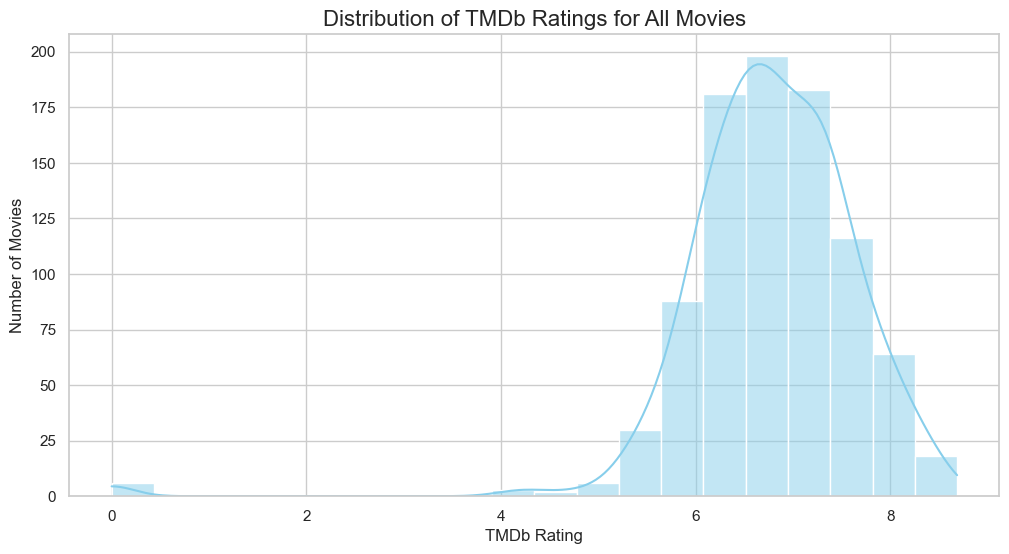

In [38]:
#Plot Distribution of TMDb Ratings

# Set plot style
sns.set(style="whitegrid")

plt.figure(figsize=(12,6))

# Plot a histogram with KDE (smooth curve)
sns.histplot(df_final['tmdb_rating'], bins=20, kde=True, color='skyblue')

# Add labels and title
plt.title("Distribution of TMDb Ratings for All Movies", fontsize=16)
plt.xlabel("TMDb Rating", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)

# Show plot
plt.show()

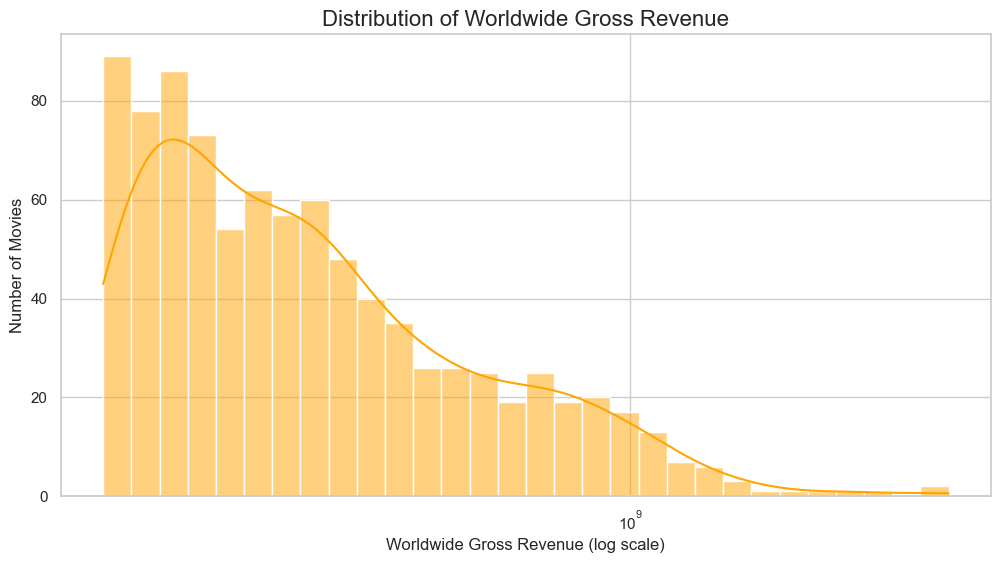

In [39]:
# Plot Distribution of Worldwide Gross

plt.figure(figsize=(12,6))

# Use log scale on x-axis because revenue varies widely
sns.histplot(df_final['Worldwide LT Gross'], bins=30, kde=True, color='orange', log_scale=(True, False))

# Add labels and title
plt.title("Distribution of Worldwide Gross Revenue", fontsize=16)
plt.xlabel("Worldwide Gross Revenue (log scale)", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)

plt.show()

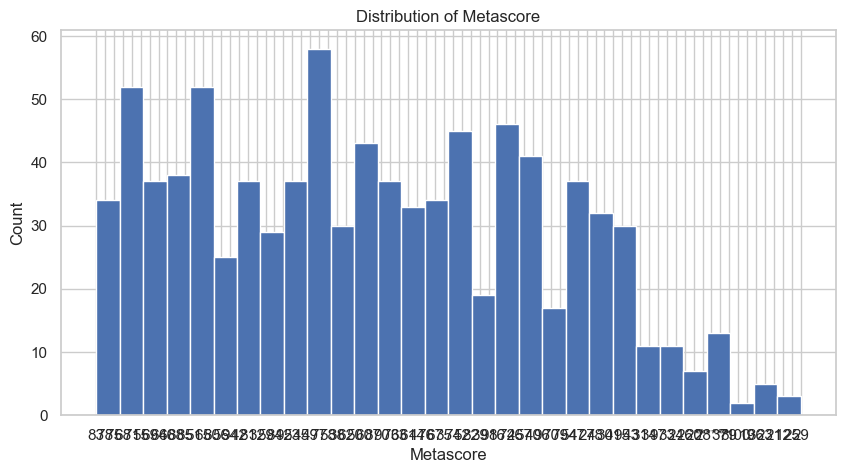

In [40]:
#Dist of meta score


plt.figure(figsize=(10,5))
plt.hist(df_final['Metascore'].dropna(), bins=30)
plt.title('Distribution of Metascore')
plt.xlabel('Metascore')
plt.ylabel('Count')
plt.show()


In [41]:
# Correlation analysis

# How numeric columns relate to each other
corr = df_final[numeric_cols].corr()
print("\nCorrelation matrix:\n", corr)

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Columns")
plt.show()

ValueError: could not convert string to float: '******'

In [42]:
# lets identify numeric problems: 

numeric_cols = ['tmdb_rating', 'imdb_rating', 'Worldwide LT Gross', 'Metascore', 'Votes', 'duration_minutes']

# Check unique values for each column to spot non-numeric entries
for col in numeric_cols:
    print(f"Unique values in {col}:")
    print(df_final[col].unique()[:20])  # print first 20 unique values
    print("----------")


Unique values in tmdb_rating:
[7.594 8.237 7.903 8.235 7.937 8.3   7.876 7.24  8.161 7.271 7.365 8.084
 6.537 7.249 7.728 7.456 6.859 6.417 7.4   6.871]
----------
Unique values in imdb_rating:
[None]
----------
Unique values in Worldwide LT Gross:
[2.84739734e+09 2.79750133e+09 2.20164726e+09 2.04835975e+09
 1.91143255e+09 1.66325049e+09 1.51881552e+09 1.45002693e+09
 1.44073974e+09 1.40280954e+09 1.34759797e+09 1.34235994e+09
 1.31046630e+09 1.28150810e+09 1.27357622e+09 1.24308924e+09
 1.23600512e+09 1.15944466e+09 1.15333750e+09 1.14852839e+09]
----------
Unique values in Metascore:
['83' '78' '75' '68' '71' '55' '69' '64' '66' '88' '85' '51' '65' '80'
 '56' '94' '42' '81' '32' '59']
----------
Unique values in Votes:
['1,236,962' '1,108,641' '1,162,142' '1,062,517' '735,006' '244,170'
 '1,381,149' '171,270' '400,255' '856,080' '751,667' '867,676' '315,318'
 '621,680' '308,027' '295,100' '231,745' '238,820' '779,525' '469,031']
----------
Unique values in duration_minutes:
[162 181

In [43]:
# Lets clean and convert to numeric, replace invalid entries ('******', empty strings, etc.) with NaN

for col in numeric_cols:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce')  # invalid parsing becomes NaN

# Check missing values after cleaning
print(df_final[numeric_cols].isnull().sum())


tmdb_rating             0
imdb_rating           895
Worldwide LT Gross      0
Metascore               3
Votes                 895
duration_minutes        0
dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_2756\1449190653.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[col] = pd.to_numeric(df_final[col], errors='coerce')  # invalid parsing becomes NaN


                    tmdb_rating  imdb_rating  Worldwide LT Gross  Metascore  \
tmdb_rating            1.000000          NaN            0.231576   0.508260   
imdb_rating                 NaN          NaN                 NaN        NaN   
Worldwide LT Gross     0.231576          NaN            1.000000   0.215868   
Metascore              0.508260          NaN            0.215868   1.000000   
Votes                       NaN          NaN                 NaN        NaN   
duration_minutes       0.309791          NaN            0.284749   0.264652   

                    Votes  duration_minutes  
tmdb_rating           NaN          0.309791  
imdb_rating           NaN               NaN  
Worldwide LT Gross    NaN          0.284749  
Metascore             NaN          0.264652  
Votes                 NaN               NaN  
duration_minutes      NaN          1.000000  


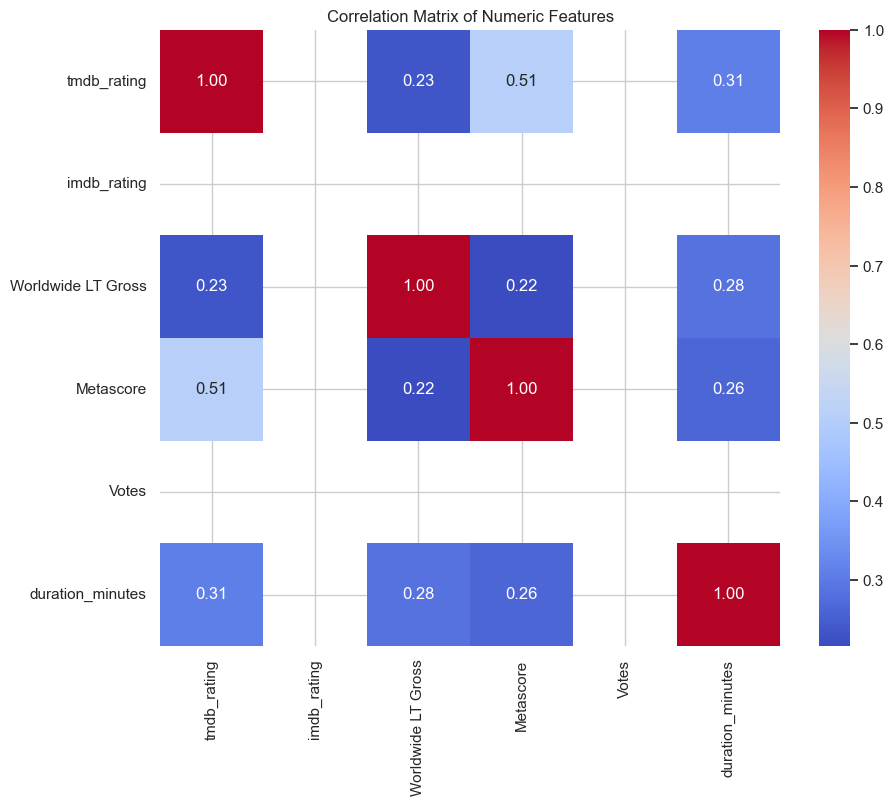

In [44]:
# Compute correlation matrix using only numeric columns
corr_matrix = df_final[numeric_cols].corr()

# Display
print(corr_matrix)

# Optional: plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()


In [45]:
#top10_gross = df_final.nlargest(10, 'Worldwide LT Gross')[['title', 'release_year', 'Worldwide LT Gross']]


top10_gross = df_final.nlargest(10, 'Worldwide LT Gross')[['title', 'release_year', 'Worldwide LT Gross']]
print("Top 10 Movies by Worldwide Box Office Gross:")
print(top10_gross)


Top 10 Movies by Worldwide Box Office Gross:
                      title  release_year  Worldwide LT Gross
0                    Avatar        2009.0        2.847397e+09
1         Avengers: Endgame        2019.0        2.797501e+09
2                   Titanic        1997.0        2.201647e+09
3    Avengers: Infinity War        2018.0        2.048360e+09
4   Spider-Man: No Way Home        2021.0        1.911433e+09
5             The Lion King        1994.0        1.663250e+09
7              The Avengers        2012.0        1.518816e+09
8                 Frozen II        2019.0        1.450027e+09
9         Top Gun: Maverick        2022.0        1.440740e+09
10  Avengers: Age of Ultron        2015.0        1.402810e+09


In [47]:
#Top 5 Movies by TMDb Rating

top5_tmdb = df_final.nlargest(5, 'tmdb_rating')[['title', 'release_year', 'tmdb_rating']]
print("\nTop 5 Movies by TMDb Rating:")
print(top5_tmdb)



Top 5 Movies by TMDb Rating:
                                             title  release_year  tmdb_rating
609                                  The Godfather        1972.0        8.685
440                               Schindler's List        1993.0        8.566
45                                 The Dark Knight        2008.0        8.525
525                                 The Green Mile        1999.0        8.503
22   The Lord of the Rings: The Return of the King        2003.0        8.491


In [48]:
#Top 10 Movies by IMDb Rating

top5_imdb = df_final.nlargest(5, 'imdb_rating')[['title', 'release_year', 'imdb_rating']]
print("\nTop 5 Movies by IMDb Rating:")
print(top5_imdb)



Top 5 Movies by IMDb Rating:
                     title  release_year  imdb_rating
0                   Avatar        2009.0          NaN
1        Avengers: Endgame        2019.0          NaN
2                  Titanic        1997.0          NaN
3   Avengers: Infinity War        2018.0          NaN
4  Spider-Man: No Way Home        2021.0          NaN


In [49]:
#Top 5 Movies by Votes

top5_votes = df_final.nlargest(5, 'Votes')[['title', 'release_year', 'Votes']]
print("\nTop 5 Movies by Number of Votes:")
print(top5_votes)



Top 5 Movies by Number of Votes:
                     title  release_year  Votes
0                   Avatar        2009.0    NaN
1        Avengers: Endgame        2019.0    NaN
2                  Titanic        1997.0    NaN
3   Avengers: Infinity War        2018.0    NaN
4  Spider-Man: No Way Home        2021.0    NaN


In [50]:
#Top 10 Movies by Metascore (Shows critical acclaim)

top10_meta = df_final.nlargest(10, 'Metascore')[['title', 'release_year', 'Metascore']]
print("\nTop 10 Movies by Metascore:")
print(top10_meta)


Top 10 Movies by Metascore:
                                             title  release_year  Metascore
609                                  The Godfather        1972.0      100.0
307                             Gone with the Wind        1939.0       97.0
117                                        Gravity        2013.0       96.0
152                                    Ratatouille        2007.0       96.0
854                               12 Years a Slave        2013.0       96.0
204                                         WALL·E        2008.0       95.0
316                                      Toy Story        1995.0       95.0
697                             The Social Network        2010.0       95.0
870                Snow White and the Seven Dwarfs        1938.0       95.0
22   The Lord of the Rings: The Return of the King        2003.0       94.0


## DATA QUALITY IMPROVEMENT / FINAL CLEANING

In [51]:
#lets reshow any missing values and maybe handle some. 

# Summary of missing values in each column
df_final.isnull().sum()

title                   0
release_year            2
genre                 895
director              895
main_cast             895
imdb_rating           895
tmdb_rating             0
mpaa_rating             0
duration_minutes        0
Worldwide LT Gross      0
Metascore               3
Votes                 895
Logline                 0
dtype: int64

In [52]:
#Release year has one missing value lets drop it (for now ill leave the others)

# Drop rows with missing release year
df_final = df_final.dropna(subset=['release_year'])


In [53]:
#Recheck

df_final.isnull().sum()

title                   0
release_year            0
genre                 893
director              893
main_cast             893
imdb_rating           893
tmdb_rating             0
mpaa_rating             0
duration_minutes        0
Worldwide LT Gross      0
Metascore               3
Votes                 893
Logline                 0
dtype: int64

In [54]:
# Show duplicate movies before removal

dups = df_final[df_final.duplicated(subset=['title', 'release_year'], keep=False)]

print("Number of duplicate rows:", len(dups))
dups[['title', 'release_year', 'Worldwide LT Gross', 'imdb_rating', 'tmdb_rating']].head(20)


Number of duplicate rows: 0


,title,release_year,Worldwide LT Gross,imdb_rating,tmdb_rating


In [56]:
#Check


dups = df_final[df_final.duplicated(subset=['title', 'release_year'], keep=False)]

print("Number of duplicate rows:", len(dups))

Number of duplicate rows: 0


In [57]:
#Lets also handle some outliers (in duration)

# Choose a column (example: duration)
col = 'duration_minutes'

Q1 = df_final[col].quantile(0.25)
Q3 = df_final[col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_final[(df_final[col] < lower_bound) | (df_final[col] > upper_bound)]

print("Number of outliers:", len(outliers))
outliers[[col, 'title', 'release_year']].head(20)

Number of outliers: 16


,duration_minutes,title,release_year
1,181,Avengers: Endgame,2019.0
2,194,Titanic,1997.0
22,201,The Lord of the Rings: The Return of the King,2003.0
56,179,The Lord of the Rings: The Two Towers,2002.0
62,178,The Lord of the Rings: The Fellowship of the Ring,2001.0
101,176,The Batman,2022.0
178,187,King Kong,2005.0
255,183,Pearl Harbor,2001.0
282,181,Dances with Wolves,1990.0
307,238,Gone with the Wind,1939.0


In [58]:
#LEts go back and handle the other missing values: 


df_final.isnull().sum()


title                   0
release_year            0
genre                 893
director              893
main_cast             893
imdb_rating           893
tmdb_rating             0
mpaa_rating             0
duration_minutes        0
Worldwide LT Gross      0
Metascore               3
Votes                 893
Logline                 0
dtype: int64

In [59]:
#Ok for the imdb rating, TMDB movies don't have IMDB rating so i'll fill with mean IMDB rating. This keeps the dataset balanced

df_final['imdb_rating'] = df_final['imdb_rating'].fillna(df_final['imdb_rating'].mean())


In [60]:
#I'll converrt the column into numeric before filling (tho this is not an error)

df_final['imdb_rating'] = pd.to_numeric(df_final['imdb_rating'], errors='coerce')
df_final['imdb_rating'] = df_final['imdb_rating'].fillna(df_final['imdb_rating'].mean())


In [61]:
#For all the categorical columns i'll just fill missing values with unknown.

df_final['genre'] = df_final['genre'].fillna('Unknown')
df_final['director'] = df_final['director'].fillna('Unknown')
df_final['main_cast'] = df_final['main_cast'].fillna('Unknown')

In [62]:
#RECHECK 

df_final.isnull().sum()

title                   0
release_year            0
genre                   0
director                0
main_cast               0
imdb_rating           893
tmdb_rating             0
mpaa_rating             0
duration_minutes        0
Worldwide LT Gross      0
Metascore               3
Votes                 893
Logline                 0
dtype: int64

In [63]:
df_final['imdb_rating'] = pd.to_numeric(df_final['imdb_rating'], errors='coerce')


In [64]:
df_final['imdb_rating'] = df_final['imdb_rating'].fillna(df_final['imdb_rating'].mean())


In [66]:
df_final.isnull().sum()

title                   0
release_year            0
genre                   0
director                0
main_cast               0
imdb_rating           893
tmdb_rating             0
mpaa_rating             0
duration_minutes        0
Worldwide LT Gross      0
Metascore               3
Votes                 893
Logline                 0
dtype: int64

In [67]:
#I guess there are weird characters thats why the rating isnt working: 

df_final['imdb_rating'] = (
    df_final['imdb_rating']
    .astype(str)
    .str.strip()
    .replace(['', 'N/A', 'NaN', 'nan', 'None', '****', '***', '**', '*'], pd.NA)
)


In [68]:
#AGain to numeric after stripping 

df_final['imdb_rating'] = pd.to_numeric(df_final['imdb_rating'], errors='coerce')

df_final['imdb_rating'] = df_final['imdb_rating'].fillna(df_final['imdb_rating'].mean())
df_final['imdb_rating'].isnull().sum()


In [69]:
df_final['imdb_rating'].unique()

array([nan])

In [70]:
df_final['imdb_rating'].notna().sum()

np.int64(0)

In [71]:
#Now i see MDB ratings never existed in the dataset. Cause i created that column and and when merged from tmdb api and the csv there where no actual values 
#I'll just drop the whole column cause its not useful

df_final = df_final.drop(columns=['imdb_rating'])

In [72]:
df_final.isnull().sum()

title                   0
release_year            0
genre                   0
director                0
main_cast               0
tmdb_rating             0
mpaa_rating             0
duration_minutes        0
Worldwide LT Gross      0
Metascore               3
Votes                 893
Logline                 0
dtype: int64

## Kafka Section

-Kafka is used when data never stops coming.

In our Data Management project, we have already processed and analyzed movie metadata and box office data from the `Top_1000_Highest_Grossing_Movies_Of_All_Time.csv` dataset.  

To demonstrate **real-time data streaming capabilities**, we integrate **Apache Kafka** into our workflow. Kafka is a distributed messaging system designed to handle **high-throughput, real-time data pipelines**. It allows data to flow from producers to consumers reliably and efficiently.

In [1]:
!pip install kafka-python pandas



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from kafka import KafkaProducer
import pandas as pd
import json

# Connect to Kafka
producer = KafkaProducer(
    bootstrap_servers='localhost:9092',  # Kafka broker
    value_serializer=lambda v: json.dumps(v).encode('utf-8')  # convert dict to JSON string
)

# Load your CSV
csv_file = 'Top_1000_Highest_Grossing_Movies_Of_All_Time.csv'
df = pd.read_csv(csv_file)

# Send only first 50 rows for demonstration
for _, row in df.head(50).iterrows():
    producer.send('movie_topic', row.to_dict())

producer.flush()
print("First 50 rows sent to Kafka topic 'movie_topic'!")


First 50 rows sent to Kafka topic 'movie_topic'!


In [3]:
from kafka import KafkaConsumer
import json

consumer = KafkaConsumer(
    'movie_topic',
    bootstrap_servers='localhost:9092',
    auto_offset_reset='earliest',      # READ OLD MESSAGES
    enable_auto_commit=True,
    value_deserializer=lambda m: json.loads(m.decode('utf-8'))
)

print("Reading messages from Kafka:")
for i, message in enumerate(consumer):
    print(f"{i+1}: {message.value}")
    if i >= 9:
        break


Reading messages from Kafka:
1: {'Movie Title': 'Avatar', 'Year of Realease': '2009', 'Genre': 'Action,Adventure,Fantasy', 'Movie Rating': 7.8, 'Duration': 162, 'Gross': '$760.51M', 'Worldwide LT Gross': '$2,847,397,339', 'Metascore': '83', 'Votes': '1,236,962', 'Logline': 'A paraplegic Marine dispatched to the moon Pandora on a unique mission becomes torn between following his orders and protecting the world he feels is his home.'}
2: {'Movie Title': 'Avengers: Endgame', 'Year of Realease': '2019', 'Genre': 'Action,Adventure,Drama', 'Movie Rating': 8.4, 'Duration': 181, 'Gross': '$858.37M', 'Worldwide LT Gross': '$2,797,501,328', 'Metascore': '78', 'Votes': '1,108,641', 'Logline': "After the devastating events of Avengers: Infinity War (2018), the universe is in ruins. With the help of remaining allies, the Avengers assemble once more in order to reverse Thanos' actions and restore balance to the universe."}
3: {'Movie Title': 'Titanic', 'Year of Realease': '1997', 'Genre': 'Drama,Rom